# Segmentation Test – EDA → Model → Train → Evaluate

## Table of Contents

0. Setup & Imports
1. Data Understanding & Exploration

   1.1 RLE Sanity Check + Visualization Samples
   1.2 Find at Least One Multi-Defect Image

2. Training Pipeline & Data Preparation
3. Model Architecture & Justification
4. Training Setup, Execution & Reporting
5. Evaluation, Interpretation & Presentation


## 0. Setup & Imports

In [1]:
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

2025-09-13 17:36:08.131816: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-13 17:36:08.158912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-13 17:36:08.845010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
os.chdir("..")

In [4]:
from src.augment import augment_basic
from src.config import CLASS_NAMES, IMG_H, IMG_W, N_CLASSES, SEED, IMAGES_DIR, CSV_PATH
from src.data import (
    basic_counts,
    build_image_table,
    name_and_mask,
    decode_rle_to_mask,
    make_dataset,
    records_from_table,
    stratified_split,
)
from src.losses import PerClassIoU, bce_dice_loss, mean_iou_from_vector
from src.model import build_unet_light
from src.viz import overlay, show_triplet

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"  # avoids huge upfront allocs
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # fallback if needed

from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy("mixed_float16")  # halves activation memory on GPU

# Prevent TF from reserving all VRAM at once
for g in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(g, True)

# Optional: place ops logging to verify GPU use
# tf.debugging.set_log_device_placement(True)
print("GPUs:", tf.config.list_logical_devices("GPU"))
print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)

GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
TF version: 2.20.0
Keras version: 3.11.3


I0000 00:00:1757795812.338245  880519 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1757795812.338697  880519 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13510 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # Filter out INFO and WARNING messages
tf.get_logger().setLevel("ERROR")

## 1. Data Understanding & Exploration
**What the CSV means:**
- `ImageId`: file name of the image.
- `ClassId`: which of the 4 defect classes is present (1–4). One image can have multiple rows.
- `EncodedPixels`: run-length encoding (RLE) of the binary mask for that class in **column-major**, **1-indexed** format.
- Images with *no defects* do **not** appear in `train.csv`; we recover them by listing the folder.

Online reference for RLE: [educative.io](https://www.educative.io/answers/how-to-perform-image-compression-using-run-length-encoding-rle)

In [6]:
full = build_image_table(CSV_PATH, IMAGES_DIR)
display(full.head())
report = basic_counts(full)
report

,class_1,class_2,class_3,class_4
ImageId,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
00031f466.jpg,NaN,NaN,NaN,NaN
000418bfc.jpg,NaN,NaN,NaN,NaN
000789191.jpg,NaN,NaN,NaN,NaN
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN


{'n_images': 12568,
 'per_class_counts': {'class_1': 897,
  'class_2': 247,
  'class_3': 5150,
  'class_4': 801},
 'multi_defect_images': 427,
 'no_defect_images': 5902,
 'imbalance_ratio': {'class_1': 0.13456345634563457,
  'class_2': 0.03705370537053705,
  'class_3': 0.7725772577257726,
  'class_4': 0.12016201620162016}}

In [7]:
wide = full[CLASS_NAMES].copy()
long4 = (
    wide.rename(columns={"class_1": 1, "class_2": 2, "class_3": 3, "class_4": 4})
    .stack(dropna=False)  # keep NaNs to mark no defect
    .reset_index()
    .rename(columns={"level_1": "ClassId", 0: "EncodedPixels"})
)
long4["ClassId"] = long4["ClassId"].astype(int)
display(long4.head(8))

/tmp/ipykernel_874199/1643586744.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)  # keep NaNs to mark no defect


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,NaN
2,0002cc93b.jpg,3,NaN
3,0002cc93b.jpg,4,NaN
4,00031f466.jpg,1,NaN
5,00031f466.jpg,2,NaN
6,00031f466.jpg,3,NaN
7,00031f466.jpg,4,NaN


**Interpretation:**
- We have `n_images` total; `per_class_counts` shows clear imbalance.
- `multi_defect_images` quantify co-occurrence; `no_defect_images` count confirms CSV omission.
- Modeling implication: (1) handle imbalance (loss/weights), (2) multi-label output (4 sigmoids), (3) expect small/elongated regions → favor overlap-aware losses and moderate resolution (1024x256).

### 1.1 RLE sanity check + visualization samples

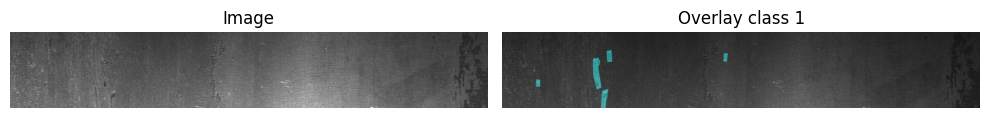

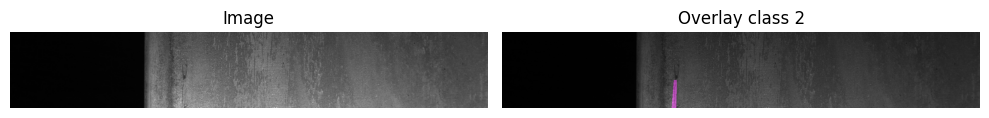

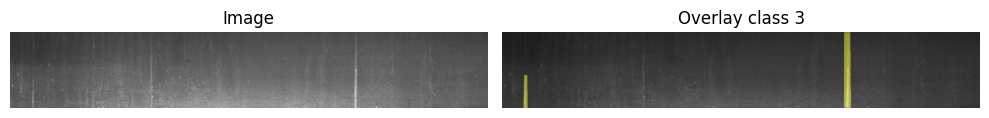

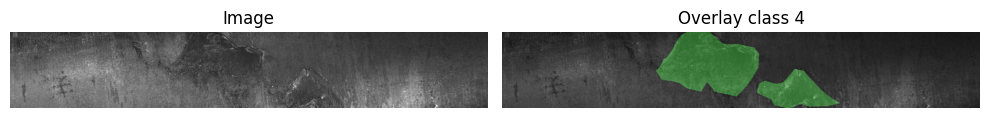

In [8]:
import matplotlib.pyplot as plt
from IPython.display import display


def plot_sample(img_id, class_id):
    path = os.path.join(IMAGES_DIR, img_id)
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32).numpy()
    h, w = img.shape[:2]
    rle = (
        full.loc[img_id, f"class_{class_id}"]
        if f"class_{class_id}" in full.columns
        else None
    )
    mask = (
        decode_rle_to_mask(rle, h, w) if pd.notna(rle) else np.zeros((h, w), np.uint8)
    )
    mask4 = np.stack(
        [(mask if i + 1 == class_id else np.zeros_like(mask)) for i in range(4)],
        axis=-1,
    )
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay(img, mask4))
    plt.title(f"Overlay class {class_id}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Show up to one example per class, if available
for cid in range(1, 5):
    rows = full[full[f"class_{cid}"].notna()].head(1)
    if len(rows):
        plot_sample(rows.index[0], cid)

### 1.2 Find at least one multi-defect image

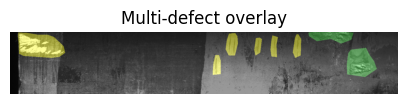

In [9]:
# Ensure the cell where `full` is defined (CELL INDEX: 9) is executed before running this cell.

# Filter the dataframe to find images with at least two defects
multi = full[full.notna().sum(axis=1) >= 2].head(1)

# Check if any multi-defect image is found
if len(multi):
    # Get the image ID of the first multi-defect image
    img_id = multi.index[0]

    # Use the name_and_mask function to get the image and mask
    _, img, mask4 = name_and_mask(img_id, full=full)

    # Plot the image with the overlaid multi-defect mask
    plt.figure(figsize=(5, 4))
    plt.imshow(overlay(img, mask4))  # Overlay the mask on the image
    plt.title("Multi-defect overlay")
    plt.axis("off")
    plt.show()
else:
    print("No multi-defect example found in the head")

**Findings and Insights**:
- Defects are small and elongated
- Multi-defect images are rare but present
- Class imbalance is significant, especially for class 2

Modeling implications:
- Use overlap-aware loss functions (e.g., Dice, Jaccard) or a imbalance-aware loss (e.g., focal loss)
- Multi-label output with 4 sigmoids

**Activation choice (why sigmoid)**:

- Classes are not mutually exclusive; a pixel can belong to multiple defect classes (overlapping skinny regions).
- Softmax would force competition between classes per pixel and under-segment overlaps.

## 2. Training Pipeline & Data Preparation
resize images & masks consistently (bilinear vs. nearest), normalize to [0,1], and apply simple augmentations that respect geometry for both tensors.

In [10]:
train_idx, val_idx = stratified_split(full, train_ratio=0.8, seed=SEED)
records = records_from_table(full, IMAGES_DIR)
train_recs = [r for r in records if os.path.basename(r["path"]) in train_idx]
val_recs = [r for r in records if os.path.basename(r["path"]) in val_idx]
train_ds = make_dataset(
    train_recs,
    batch=2,
    shuffle=True,
    augment_fn=augment_basic,
    shuffle_buffer=256,
    nmap=4,
    prefetch_size=2,
)

val_ds = make_dataset(
    val_recs,
    batch=2,
    shuffle=False,
    augment_fn=None,
    shuffle_buffer=64,
    nmap=2,
    prefetch_size=1,
)

train_ds, val_ds

(<_OptionsDataset element_spec=(TensorSpec(shape=(None, 256, 1024, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 1024, 4), dtype=tf.float32, name=None))>,
 <_OptionsDataset element_spec=(TensorSpec(shape=(None, 256, 1024, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 1024, 4), dtype=tf.float32, name=None))>)

**Why this resolution?**
- `1024x256` is a pragmatic compromise for a 2-hour window—fast enough to train 3-4 epochs while preserving shape cues. If I had more time/GPU memory, I'd stick to the original scale with random crops.

**Augmentations:** H-flip + mild brightness/contrast to generalize without breaking mask alignment.

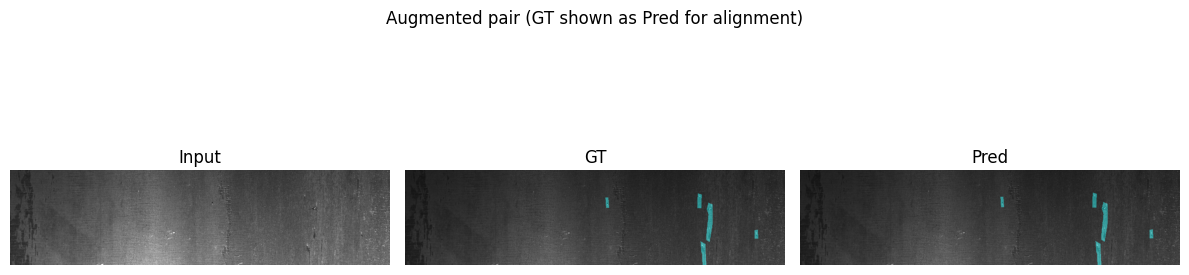

Image shape: (256, 1024, 3) Mask shape: (256, 1024, 4)


2025-09-13 17:07:20.788729: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Show one augmented pair to confirm alignment
sample = train_recs[0]  # from the training set
tmp_ds = make_dataset(
    [sample], batch=1, shuffle=False, augment_fn=augment_basic, seed=SEED
)
for xb, yb in tmp_ds.take(1):
    img_aug, mask_aug = xb[0].numpy(), yb[0].numpy()
    show_triplet(
        img_aug,
        mask_aug,
        mask_aug,
        title="Augmented pair (GT shown as Pred for alignment)",
    )
print("Image shape:", img_aug.shape, "Mask shape:", mask_aug.shape)

## 3. Model Architecture & Justification

In [12]:
model = build_unet_light()
model.summary(line_length=120)

Model: "unet_light"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 256, 1024, 3)         │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d (Conv2D)                   │ (None, 256, 1024, 16)        │               448 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization               │ (None, 256, 1024, 16)        │                64 │ conv2d[0][0]              
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation (Activation)           │ (None, 256, 1024, 16)        │                 0 │ batch_normalization[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_1 (Conv2D)                 │ (None, 256, 1024, 16)        │             2,320 │ activation[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_1             │ (None, 256, 1024, 16)        │                64 │ conv2d_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_1 (Activation)         │ (None, 256, 1024, 16)        │                 0 │ batch_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d (MaxPooling2D)      │ (None, 128, 512, 16)         │                 0 │ activation_1[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_2 (Conv2D)                 │ (None, 128, 512, 32)         │             4,640 │ max_pooling2d[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_2             │ (None, 128, 512, 32)         │               128 │ conv2d_2[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_2 (Activation)         │ (None, 128, 512, 32)         │                 0 │ batch_normalization_2[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_3 (Conv2D)                 │ (None, 128, 512, 32)         │             9,248 │ activation_2[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_3             │ (None, 128, 512, 32)         │               128 │ conv2d_3[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_3 (Activation)         │ (None, 128, 512, 32)         │                 0 │ batch_normalization_3[0][0
├───────────────────────────────────┼───────────────────

 Total params: 1,968,564 (7.51 MB)

 Trainable params: 1,965,620 (7.50 MB)

 Non-trainable params: 2,944 (11.50 KB)

**Justification:**
- U-Net variant balances speed and capacity for small/elongated defects
- Using sigmoid 4-channel output matches multi-label masks.

## 4. Training Setup, Execution & Reporting

In [13]:
per_class_iou = PerClassIoU(name="per_class_iou")

In [14]:
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"  # disable XLA auto-JIT
tf.config.optimizer.set_jit(False)  # safety
# when compiling:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=bce_dice_loss,
    metrics=[
        per_class_iou,
        lambda y_t, y_p: mean_iou_from_vector(per_class_iou.result()),
    ],
    jit_compile=False,
    steps_per_execution=16,  # amortize Python overhead
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best.keras", monitor="val_loss", save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1
    ),
    keras.callbacks.CSVLogger("training_log.csv", append=False),
]

In [15]:
STEPS = 400
VAL_STEPS = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3, # use 8 or more for real training
    steps_per_epoch=STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks,
)

Epoch 1/3


2025-09-13 17:07:25.487541: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-09-13 17:07:25.609175: I external/local_xla/xla/service/service.cc:163] XLA service 0x745d8c006460 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-09-13 17:07:25.609229: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1757794045.713563  874278 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/400 ━━━━━━━━━━━━━━━━━━━━ 52:15 12s/step - lambda: 0.0106 - loss: 0.7197 - per_class_iou: 0.0109

: 

: 

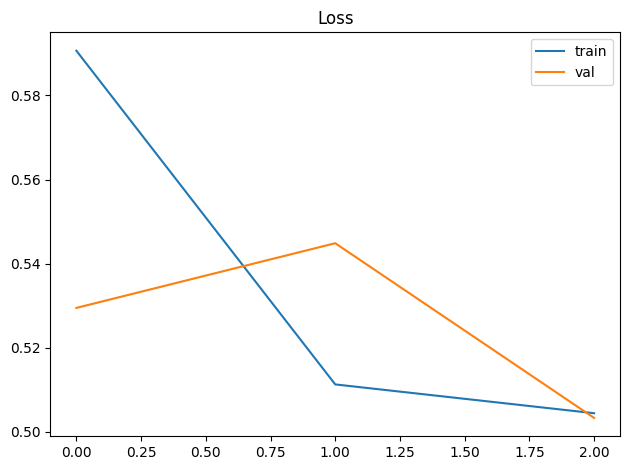

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

## 5. Evaluation, Interpretation & Presentation

In [ ]:
# Compute per-class IoU vector and mean IoU
ths = np.linspace(0.3, 0.7, 5)
best = []
for t in ths:
    per_class_iou.reset_states()
    for xb, yb in val_ds:
        preds = model.predict(xb, verbose=0)
        per_class_iou.update_state(yb, (preds > t).astype(np.float32))
    iou_vec = per_class_iou.result().numpy().copy()
    best.append((t, per_class_iou.result().numpy().copy()))
best_t, best_vec = max(best, key=lambda kv: kv[1].mean())
print("best_th:", best_t, "| per-class:", best_vec, "| mIoU:", best_vec.mean())

2025-09-13 16:22:16.671696: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


best_th: 0.5 | per-class: [1.8089921e-13 7.9755630e-13 1.8977296e-01 2.6490698e-14] | mIoU: 0.04744324


**Pixel accuracy**:
- Across all channels (multi-label)
- Exact channel match
- All pixels accuracy vs. non-background pixels only

In [ ]:
# accuracy on all pixels
total = 0
correct = 0
for xb, yb in val_ds:
    preds = model.predict(xb, verbose=0)
    pb = (preds > 0.5).astype(np.uint8)  # [B,H,W,4]
    y = yb.numpy().astype(np.uint8)  # [B,H,W,4]
    eq = pb == y
    correct += np.sum(eq)  # count all equal channels
    total += eq.size
pixel_acc = correct / total

# accuracy only on pixels that are not all-background
correct_nb = 0
total_nb = 0
for xb, yb in val_ds:
    preds = model.predict(xb, verbose=0)
    pb = (preds > 0.5).astype(np.uint8)
    y = yb.numpy().astype(np.uint8)
    nonbg = (
        y.sum(axis=-1) + pb.sum(axis=-1)
    ) > 0  # [B,H,W] any class active in GT or Pred
    eq = pb == y  # [B,H,W,4]
    nonbg_expanded = np.broadcast_to(
        nonbg[..., None], eq.shape
    )  # Expand nonbg to match eq's shape
    correct_nb += np.sum(eq[nonbg_expanded])
    total_nb += np.sum(nonbg_expanded)
pixel_acc_nonbg = correct_nb / max(1, total_nb)

# IoU table
metrics_df = pd.DataFrame(
    {"Class": [f"Class {i}" for i in range(1, 5)], "IoU": [float(v) for v in iou_vec]}
)
display(metrics_df.style.format({"IoU": "{:.4f}"}))
print(f"Mean IoU = {np.mean(iou_vec):.4f} | Pixel Accuracy = {pixel_acc:.4f}")

,Class,IoU
0,Class 1,0.0000
1,Class 2,0.0000
2,Class 3,0.1834
3,Class 4,0.0000


Mean IoU = 0.0459 | Pixel Accuracy = 0.9884


Qualitative: successes and failures (include a no-defect if present)

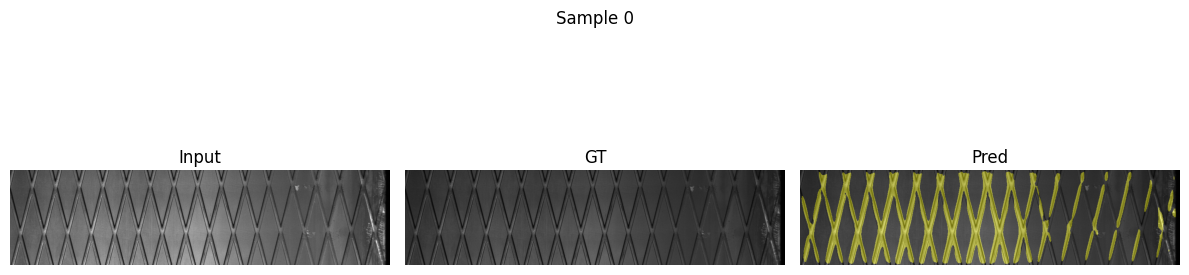

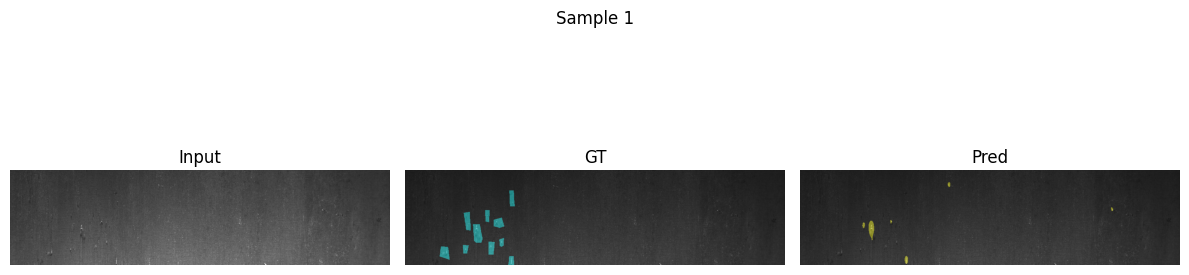

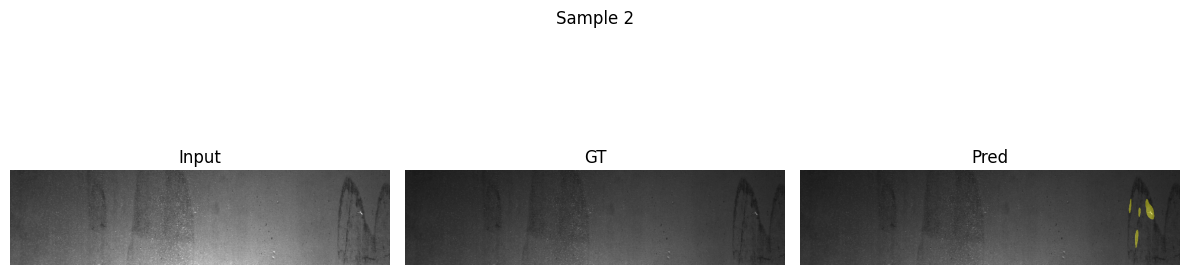

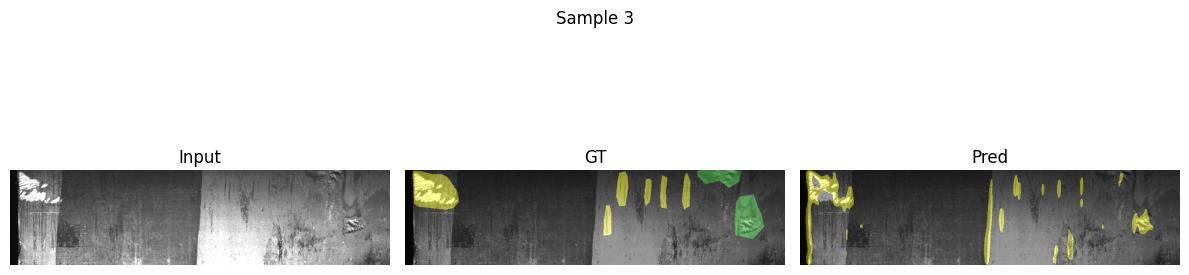

In [ ]:
shown = 0
for xb, yb in val_ds:
    preds = model.predict(xb, verbose=0)
    for i in range(min(4, xb.shape[0])):
        show_triplet(xb[i].numpy(), yb[i].numpy(), preds[i], title=f'Sample {shown}')
        shown += 1
    if shown >= 4: break

**Interpretation:**

- Classes 1/2/4 are much rarer (data imbalance) = lower IoU
  - early epochs + small batch means the model optimizes background and the most frequent/easiest structure first (Class 3). IoU is harsh on thin/elongated defects—a few-pixel misalignment zeroes IoU.
- Many pixels contain no positives
  - This means slowing learning for rare classes.
- Pixel accuracy looks high (0.988) because background is easy
  - non-background acc (0.788) is more representative
  - Still, IoU is low due to boundary sensitivity
  - Small masks make IoU volatile

**Insights (grounded in EDA and errors):**

- Hard classes likely align with those that are rarer and/or very small in area.
- Missed skinny regions → consider higher input size or multiscale features.
- False positives on background → threshold tuning or focal component.

**Next steps if time allowed:**

- oversample positives and use positive-aware crops, add class-weighted BCE + Dice, and tune per-class thresholds on validation
- with more time, increase capacity slightly and add dilated convs for context
- explore using more advanced augmentation techniques to improve model robustness